<a href="https://colab.research.google.com/github/cmansoo/funko-pop-cnn/blob/main/MansooNet_gender_and_initial_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this notebook, we will train a CNN from scratch on our classification problem regarding "Gender." The goal is to find optimal model structure as well as a set of hyper parameters. The resulting model will be saved as "MansooNet"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPooling2D, BatchNormalization, Conv2D, Dropout, Activation, Dense, Flatten, AveragePooling2D, InputLayer, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.optimizers import SGD
from imblearn.over_sampling import SMOTE
from itertools import product
from keras.metrics import Recall
from keras.utils import plot_model

In [ ]:
# mount drive
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Colab Notebooks/SEIS 764/project")
!ls

Mounted at /content/drive
'764 final project images'		       'grid search example using a loop.ipynb'
 classfiers.ipynb			        image_gen.ipynb
 Copy_of_764project_gender_optimization.ipynb  'MansooNet - gender and initial training.ipynb'
 data					        MansooNet.h5
 funko_file_map.csv			        model.png
 gender_after_smote_cnn2flatten.h5	       'SEIS764 project.ipynb'
 gender_after_smote_flatten2dense.h5	        test.csv
 gender_before_smote.h5			        test.gsheet
 gender_final.h5			       'Untitled document.gdoc'


## Read Data and split


In [ ]:
funko_df = pd.read_csv("funko_file_map.csv")
# remove unnecessary paths
funko_df["Image Path"] = funko_df["Image Path"].str.replace("drive/MyDrive/SEIS764/", "")

# change boolean columns to strings
for col in funko_df.columns.drop(["Image Path", "Gender", "Name"]):
  funko_df[col] = np.where(funko_df[col], "y", "n")

# split
train_df, test_df = train_test_split(funko_df, test_size=0.2, random_state=100)
print("train dataset", train_df.shape)
display(train_df)
print("test dataset", test_df.shape)
display(test_df)

train dataset (212, 9)


,Image Path,Human,Gender,Facial Hair,Glasses,Hat,Item in hand,Sunny,Name
180,764 final project images/Towelie6.jpeg,n,m,n,n,n,n,n,Towelie
260,764 final project images/SteamBoatWilly4.jpeg,n,o,n,n,y,n,n,SteamBoatWilly
201,764 final project images/CokeBear7.jpeg,n,o,n,n,n,y,n,CokeBear
171,764 final project images/WildThing4.jpeg,n,o,y,n,n,n,n,WildThing
230,764 final project images/Max6.jpeg,n,o,n,n,n,n,n,Max
...,...,...,...,...,...,...,...,...,...
226,764 final project images/Max2.jpeg,n,o,n,n,n,n,n,Max
66,764 final project images/Gohan2.jpeg,y,m,n,n,y,n,n,Gohan
53,764 final project images/Grommit6.jpeg,n,o,n,n,n,n,n,Grommit
79,764 final project images/Vegeta8.jpeg,y,m,n,n,n,n,n,Vegeta


test dataset (53, 9)


,Image Path,Human,Gender,Facial Hair,Glasses,Hat,Item in hand,Sunny,Name
243,764 final project images/MrPB5.jpeg,n,o,n,n,y,y,n,MrPB
160,764 final project images/Tony.jpeg,y,m,n,n,n,y,n,Tony
257,764 final project images/Micky6.jpeg,n,o,n,n,y,n,n,Micky
256,764 final project images/SteamBoatWilly.jpeg,n,o,n,n,y,n,n,SteamBoatWilly
110,764 final project images/PickleRick3.jpeg,n,o,n,n,n,y,n,PickleRick
236,764 final project images/Rick.jpeg,y,m,n,n,n,y,n,Rick
52,764 final project images/Grommit4.jpeg,n,o,n,n,n,n,n,Grommit
263,764 final project images/SteamBoatWilly8.jpeg,n,o,n,n,y,n,n,SteamBoatWilly
97,764 final project images/Gimli5.jpeg,y,m,y,n,y,y,n,Gimli
245,764 final project images/MrPB4.jpeg,n,o,n,n,y,y,n,MrPB


## Define functions

In [ ]:
# image preprocessing
def img_preprocess(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    y_name: str,
    target_size: tuple[int, int],
    batch_size: int,
    class_mode: str
    ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

  train_datagen = ImageDataGenerator(
      rescale=1./255.,
      validation_split=0.2,
      shear_range=0.2,
      zoom_range=0.2, #augmentation params, experiment later
      vertical_flip=True
  )

  test_datagen = ImageDataGenerator(rescale=1./255.)

  train_data = train_datagen.flow_from_dataframe(
      dataframe=df_train,
      x_col="Image Path",
      y_col=y_name,
      target_size=target_size,
      batch_size=batch_size,
      class_mode=class_mode,
      shuffle=False,
      subset="training"
  )

  val_data = train_datagen.flow_from_dataframe(
      dataframe=df_train,
      x_col="Image Path",
      y_col=y_name,
      target_size=target_size,
      batch_size=batch_size,
      class_mode=class_mode,
      shuffle=False,
      subset="validation"
  )

  test_data = test_datagen.flow_from_dataframe(
      dataframe=df_test,
      x_col="Image Path",
      y_col=y_name,
      target_size=target_size,
      batch_size=1,
      class_mode=class_mode,
      shuffle=False
  )

  return (train_data, val_data, test_data)

# create model
#------------------------ new structure ---------------------------
# still needs some experiment, requires longer epochs
def create_full_model(
    target_size: tuple[int, int],
    num_class: int
):
  model = Sequential()

  # conv 1
  model.add(InputLayer(input_shape = target_size + (num_class,)))
  model.add(Conv2D(filters=72, kernel_size=(11,11), strides=3, padding="valid"))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding="valid"))
  # model.add(AveragePooling2D(pool_size=(3,3)))

  # conv 2
  model.add(Conv2D(filters=144, kernel_size=(7,7), padding="same"))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(3,3)))

  # conv 3
  model.add(Conv2D(filters=216, kernel_size=(5,5), padding="same"))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  # model.add(MaxPooling2D(pool_size=(2,2)))

  # conv 4
  model.add(Conv2D(filters=360, kernel_size=(3,3), padding="same"))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # flatten
  model.add(Flatten(name="flatten_1"))

  # dense
  model.add(Dense(units=4200, activation="relu"))
  model.add(Dropout(0.4))
  model.add(Dense(units=1500, activation="relu"))
  model.add(Dropout(0.4))
  model.add(Dense(units=600, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(units=250, activation="relu"))
  model.add(Dense(units=100, activation="relu"))
  model.add(Dense(units=50, activation="relu"))
  model.add(Dense(units=20, activation="relu"))
  model.add(Dense(units=8, activation="relu"))
  model.add(Dense(units=num_class, activation="softmax"))

  return model

#-----------------------------------------------------------------------

# plot model history
def plot_history(history):
  plt.plot(history.history["accuracy"])
  plt.plot(history.history["val_accuracy"])
  plt.legend(labels=["Accuracy", "Validation Accuracy"])
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title("Training History")
  plt.show()

# evaluate the model and report
# option to choose which data to evaluate on
def make_eval_reports(model, train_dat, test_dat, vm=20, eval_opt="test"):
  # reset
  train_dat.reset()
  test_dat.reset()

  if eval_opt == "test":
    pred_scores = model.predict(test_dat, verbose=True)
    pred_labels = pred_scores.argmax(axis=1)
    true_labels = test_dat.labels
  elif eval_opt == "train":
    pred_score = model.predict(train_dat, verbose=True)
    pred_labels = pred_scores.argmax(axis=1)
    true_labels = train_dat.labels
  else:
    raise Exception("invalid parameter for `eval_opt`. Choose from 'test' or 'train'.")

  print("predicted labels: \n", pred_labels)
  print("\n {} data labels:\n".format(eval_opt), true_labels)

  accuracy = accuracy_score(true_labels, pred_labels)
  cm = confusion_matrix(true_labels, pred_labels)
  cr = classification_report(true_labels, pred_labels)

  # report metrics
  print("\n {0} data accuracy score: {1:.2f}".format(eval_opt, accuracy))
  print("\n confusion matrix: \n", cm)
  print("\n classification report", cr)

  # plot confusion matrix
  cm_plot = sns.heatmap(cm, linewidths=1, vmax=vm, square=True, cmap="Blues", annot=True)
  plt.title("{} data confusion matrix".format(eval_opt))
  plt.show()

  # roc and auc
  onehot_test_label = pd.get_dummies(test_dat.labels).to_numpy()
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_class):
    fpr[i], tpr[i], _ = roc_curve(onehot_test_label[:,i], pred_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"class {i}")

  plt.xlabel('\nFalse Positive Rate')
  plt.ylabel('\nTrue Positive Rate')
  plt.title("\nROC curve")
  plt.legend()
  plt.show()
  print("\nAUC: ", roc_auc)

  return accuracy, cm, cr, cm_plot

# # extract z-code up to flatten layer
# def z_code_flatten(full_model, train_dat):
#   upto_flatten = Model(inputs=full_model.input, outputs=full_model.get_layer("flatten_1").output)
#   z_code = upto_flatten.predict(train_dat)
#   z_labels = np.array(train_dat.labels)

#   return upto_flatten, z_code, z_labels

# oversample the flatten layer using SMOTE
def my_smote(z, z_lab, nn=5):
  """
  z: extracted z-code (cnn 2 flatten) to oversample
  z_lab: train_labels or test labels
  nn: number of neighbors for SMOTE
  """

  sampler = SMOTE(k_neighbors=nn, random_state=100)
  z_oversampled, z_lab_new = sampler.fit_resample(z, z_lab)
  z_oversampled_y = pd.get_dummies(z_lab_new).to_numpy()

  return z_oversampled, z_oversampled_y
##### visualize label counts
def plot_label_counts(z_labels, opt):
  """
  z_labels: np.array (or list might work?) of train labels
  opt: option for title - 'before' or 'after' oversampling
  """
  unique, counts = np.unique(z_labels, return_counts=True)
  counter = dict(zip(unique, counts))
  # print counts
  for lab, ct in counter.items():
    print("class {}: n = {}".format(lab, ct))
  # plot
  plt.bar(counter.keys(), counter.values())
  plt.title("counts {} oversampling".format(opt))
  plt.show()


# #### create a model for dense layer only
# def create_flatten2dense(n_class):
#   # build the second part
#   new_dense = Sequential()

#   # dense layers
#   new_dense.add(Dense(units=3456, activation="relu", input_shape=(6912,)))
#   new_dense.add(Dropout(0.3))
#   new_dense.add(Dense(units=1728, activation="relu"))
#   new_dense.add(Dropout(0.2))
#   new_dense.add(Dense(units=864, activation="relu"))
#   new_dense.add(Dropout(0.2))
#   new_dense.add(Dense(units=432, activation="relu"))
#   new_dense.add(Dropout(0.2))
#   new_dense.add(Dense(units=216, activation="relu"))
#   new_dense.add(Dropout(0.2))
#   new_dense.add(Dense(units=108, activation="relu"))
#   new_dense.add(Dense(units=54, activation="relu"))
#   new_dense.add(Dense(units=27, activation="relu"))
#   new_dense.add(Dense(units=12, activation="relu"))
#   new_dense.add(Dense(units=6, activation="relu"))
#   new_dense.add(Dense(units=n_class, activation="softmax"))

#   return new_dense

## 1. Fit a model for **Gender**.

The approach is to fit a model on **Gender** from scratch. Keep a good train result. Then use the CNN2Flatten layer, save it and do classification for other labels. The idea is to find the best hyper parameters for layers `upto_flatten` and use it for other layers

### a. without SMOTE

1. first set
epoch = [50]
batch size = [16, 32]
learning rate = 0.001
momentum = 0.9

image augmentation params:
zoom_range=0.2,
vertical_flip=True,
shear_range=0.2

model structure below:

structure 1.



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 72, 72, 72)        26208     
                                                                 
 batch_normalization_8 (Bat  (None, 72, 72, 72)        288       
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (None, 72, 72, 72)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 35, 35, 72)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 35, 35, 144)       508176    
                                                                 
 batch_normalization_9 (Bat  (None, 35, 35, 144)      

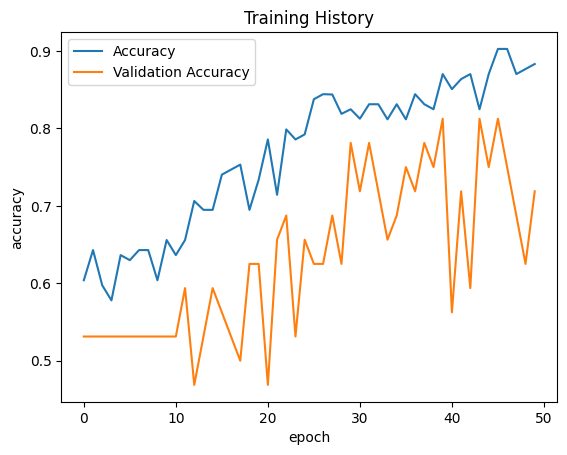

53/53 [==============================] - 29s 547ms/step
predicted labels: 
 [2 2 2 2 2 2 2 2 1 2 1 2 2 1 2 2 1 1 1 2 2 1 2 1 2 1 1 2 1 2 2 1 1 2 1 1 1
 2 1 1 2 1 2 2 1 1 2 1 2 1 1 2 2]

 test data labels:
 [2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1]

 test data accuracy score: 0.66

 confusion matrix: 
 [[ 0  3  0]
 [ 0 19 13]
 [ 0  2 16]]

 classification report               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.79      0.59      0.68        32
           2       0.55      0.89      0.68        18

    accuracy                           0.66        53
   macro avg       0.45      0.49      0.45        53
weighted avg       0.67      0.66      0.64        53



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


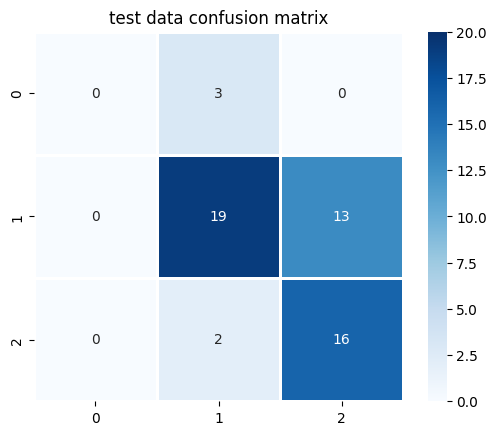

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 72, 72, 72)        26208     
                                                                 
 batch_normalization_12 (Ba  (None, 72, 72, 72)        288       
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 72, 72, 72)        0         
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 35, 35, 72)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 35, 35, 144)       508176    
                                                                 
 batch_normalization_13 (Ba  (None, 35, 35, 144)      

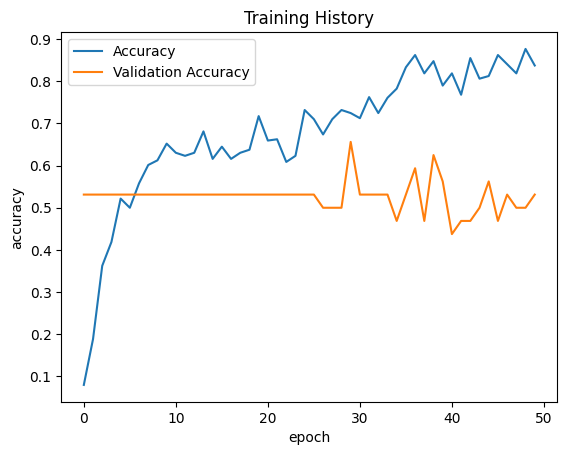

53/53 [==============================] - 10s 179ms/step
predicted labels: 
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2
 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 2]

 test data labels:
 [2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1]

 test data accuracy score: 0.42

 confusion matrix: 
 [[ 0  0  3]
 [ 0  4 28]
 [ 0  0 18]]

 classification report               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       1.00      0.12      0.22        32
           2       0.37      1.00      0.54        18

    accuracy                           0.42        53
   macro avg       0.46      0.38      0.25        53
weighted avg       0.73      0.42      0.32        53



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


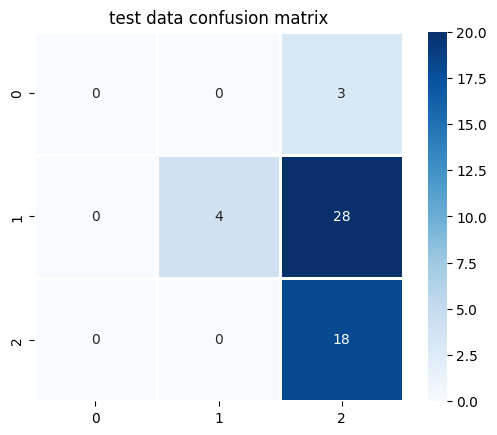

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 72, 72, 72)        26208     
                                                                 
 batch_normalization_16 (Ba  (None, 72, 72, 72)        288       
 tchNormalization)                                               
                                                                 
 activation_16 (Activation)  (None, 72, 72, 72)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 35, 35, 72)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 35, 35, 144)       508176    
                                                                 
 batch_normalization_17 (Ba  (None, 35, 35, 144)      

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-ae39c6582918>", line 74, in <cell line: 47>
    history = gender_model.fit(train_data, epochs=ep,
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 60, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
OSError: [Errno 107] Transport endpoint is not connected
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.

In [ ]:
# parameters
target_size = (224, 224)
epoch_list = [50]
batch_size_list = [16, 32]
n_class = 3
eval_dict = {"accuracy":[],
             "cm":[],
             "cr":[],
             "tr_time":[]
             }


# store the best hyper parameters and corresponding accuracy
best_params = None
best_accuracy = 0.0
best_model = None


# iterate through hyper parameters
for ep, bs in product(epoch_list, batch_size_list):

  # create model for gender
  gender_model = create_full_model(target_size, n_class)
  gender_model.summary()

  # compile
  gender_model.compile(loss="categorical_crossentropy", optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=["accuracy"])

  # generate data
  train_data, val_data, test_data = img_preprocess(
      df_train=train_df,
      df_test=test_df,
      y_name="Gender",
      target_size=target_size,
      batch_size=bs,
      class_mode="categorical"
  )
  train_num = train_data.samples
  val_num = val_data.samples

  # train
  print("\nTraining with epochs={}, batch size={}".format(ep, bs))
  # record start time
  start_time = time.time()

  # fit
  history = gender_model.fit(train_data, epochs=ep,
                             steps_per_epoch=train_num // bs,
                             validation_data=val_data,
                             validation_steps=val_num // bs,
                             verbose=True)

  # record endtime
  end_time = time.time()

  print(f"\nTraining with Epochs={ep}, Batch Size={bs}")
  training_time = (end_time - start_time)/60
  print(f'Model Training + Validation Time: {training_time:.2f} minutes')
  # plot history
  plot_history(history)

  # evaluate and store results
  accuracy, cm, cr, _ = make_eval_reports(gender_model, train_data, test_data, 20, eval_opt="test")
  eval_dict["accuracy"].append(accuracy)
  eval_dict["cm"].append(cm)
  eval_dict["cr"].append(cr)
  eval_dict["tr_time"].append(training_time)

  # store the best hyper paramters
  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_params = (ep, bs)
    best_model = gender_model

# Print the best hyperparameters
print("\nBest Hyperparameters:")
print(f"Epochs: {best_params[0]}, Batch Size: {best_params[1]}")

### Still initial training,

set 2 parameters:

target size = (224, 224)
epoch: 75
batch size = 8
learning rate = 0.001
momentum = 0.9

not enough learning, increase epoch.


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 72, 72, 72)        26208     
                                                                 
 batch_normalization_8 (Bat  (None, 72, 72, 72)        288       
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (None, 72, 72, 72)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 35, 35, 72)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 35, 35, 144)       508176    
                                                                 
 batch_normalization_9 (Bat  (None, 35, 35, 144)      

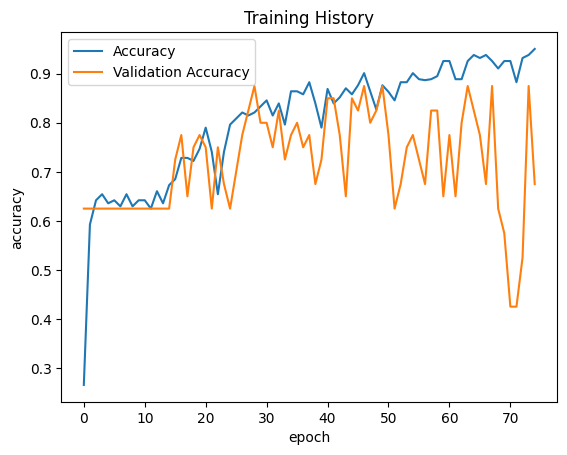

53/53 [==============================] - 24s 450ms/step
predicted labels: 
 [2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 1 1 2 1 2 1 2 2 2 1 2 1 1 1 2 2 1 1 2 2 1 2
 2 2 1 2 2 2 2 2 1 2 2 2 1 1 2 1]

 test data labels:
 [2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1]

 test data accuracy score: 0.70

 confusion matrix: 
 [[ 0  0  3]
 [ 0 19 13]
 [ 0  0 18]]

 classification report               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       1.00      0.59      0.75        32
           2       0.53      1.00      0.69        18

    accuracy                           0.70        53
   macro avg       0.51      0.53      0.48        53
weighted avg       0.78      0.70      0.68        53



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


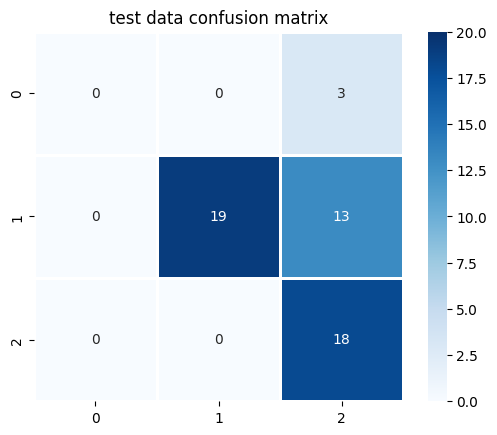

NameError: ignored

In [ ]:
# parameters
target_size = (224, 224)
epoch = 75
batch_size = 8
n_class = 3


# create model for gender
gender_model = create_full_model(target_size, n_class)
gender_model.summary()

# compile
gender_model.compile(loss="categorical_crossentropy", optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=["accuracy"])

# generate data
train_data, val_data, test_data = img_preprocess(
    df_train=train_df,
    df_test=test_df,
    y_name="Gender",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical"
)
train_num = train_data.samples
val_num = val_data.samples

# train
print("\nTraining with epochs={}, batch size={}".format(epoch, batch_size))
# record start time
start_time = time.time()

# fit
history = gender_model.fit(train_data, epochs=epoch,
                            steps_per_epoch=train_num // batch_size,
                            validation_data=val_data,
                            validation_steps=val_num // batch_size,
                            verbose=True)

# record endtime
end_time = time.time()

print(f"\nTraining with Epochs={epoch}, Batch Size={batch_size}")
training_time = (end_time - start_time)/60
print(f'Model Training + Validation Time: {training_time:.2f} minutes')
# plot history
plot_history(history)

# evaluate and store results
accuracy, cm, cr, _ = make_eval_reports(gender_model, train_data, test_data, 20, eval_opt="test")

## parameter set 3

target_size = (224, 224)
epoch = 100,
batch size = 8
learning rate = 0.001
momentum = 0.9

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 72, 72, 72)        26208     
                                                                 
 batch_normalization_16 (Ba  (None, 72, 72, 72)        288       
 tchNormalization)                                               
                                                                 
 activation_16 (Activation)  (None, 72, 72, 72)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 35, 35, 72)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 35, 35, 144)       508176    
                                                                 
 batch_normalization_17 (Ba  (None, 35, 35, 144)      

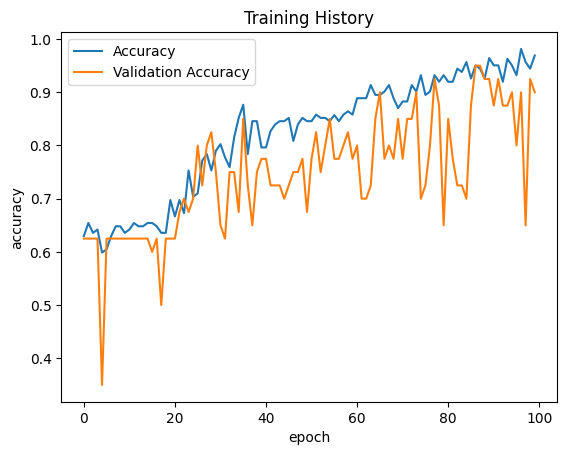

53/53 [==============================] - 11s 191ms/step
predicted labels: 
 [2 1 2 2 2 1 2 1 1 2 1 2 1 2 2 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 2 2 1 1
 2 2 1 2 1 2 2 1 1 2 1 2 1 1 1 1]

 test data labels:
 [2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1]

 test data accuracy score: 0.89

 confusion matrix: 
 [[ 0  0  3]
 [ 0 31  1]
 [ 0  2 16]]

 classification report               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.94      0.97      0.95        32
           2       0.80      0.89      0.84        18

    accuracy                           0.89        53
   macro avg       0.58      0.62      0.60        53
weighted avg       0.84      0.89      0.86        53



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


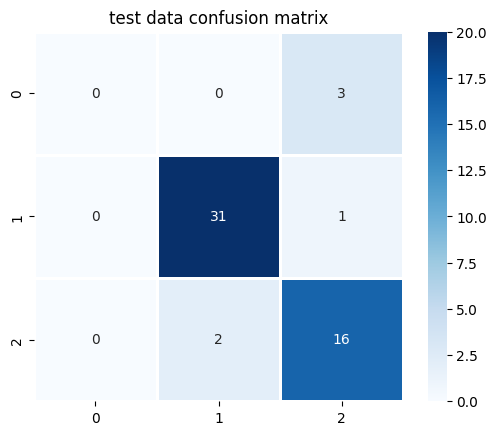

In [ ]:
# parameters
target_size = (224, 224)
epoch = 100
batch_size = 8
n_class = 3

# create model for gender
final_gender_model = create_full_model(target_size, n_class)
final_gender_model.summary()

# compile
final_gender_model.compile(loss="categorical_crossentropy", optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=["accuracy"])

# generate data
train_data, val_data, test_data = img_preprocess(
      df_train=train_df,
      df_test=test_df,
      y_name="Gender",
      target_size=target_size,
      batch_size=batch_size,
      class_mode="categorical"
  )
train_num = train_data.samples
val_num = val_data.samples


# train
print("\nTraining with epochs={}, batch size={}".format(epoch, batch_size))
# record start time
start_time = time.time()

# fit
final_history = final_gender_model.fit(train_data, epochs=epoch,
                            steps_per_epoch=train_num // batch_size,
                            validation_data=val_data,
                            validation_steps=val_num // batch_size,
                            verbose=True)

# record endtime
end_time = time.time()

print(f"\nTraining with Epochs={epoch}, Batch Size={batch_size}")
training_time = (end_time - start_time)/60
print(f'Model Training + Validation Time: {training_time:.2f} minutes')
# plot history
plot_history(final_history)

# evaluate and store results
accuracy, cm, cr, _ = make_eval_reports(final_gender_model, train_data, test_data, 20, eval_opt="test")

In [ ]:
# save model
final_gender_model.save("MansooNet - full_model_gender.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


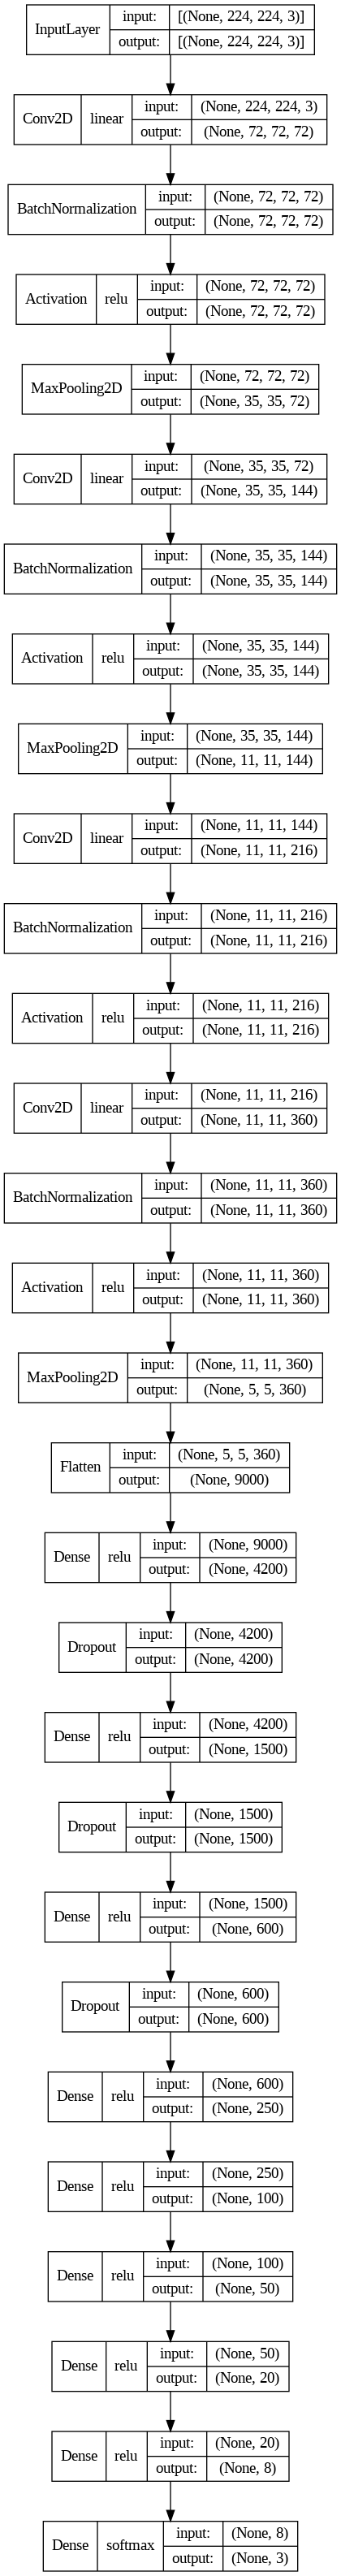

In [ ]:
# plot model structure
plot_model(final_gender_model, show_shapes=True, show_layer_activations=True, show_layer_names=False)